Postgresql in terminal:


```bash
$ sudo service postgresql start

~/UE-Germany/ps25_bigdata/Sentiment_Tiktok/scripts on  Setup! ⌚ 14:41:01
$ sudo -u postgres psql
could not change directory to "/home/alex/UE-Germany/ps25_bigdata/Sentiment_Tiktok/scripts": Permission denied
psql (14.18 (Ubuntu 14.18-0ubuntu0.22.04.1))
Type "help" for help.

postgres=# CREATE DATABASE sentiment_analysis;
CREATE USER alex WITH PASSWORD '###########';
GRANT ALL PRIVILEGES ON DATABASE sentiment_analysis TO alex;
\q
CREATE DATABASE
CREATE ROLE
GRANT

~/UE-Germany/ps25_bigdata/Sentiment_Tiktok/scripts on  Setup! ⌚ 14:43:11
$ psql -U alex -d sentiment_analysis

psql (14.18 (Ubuntu 14.18-0ubuntu0.22.04.1))
Type "help" for help.

sentiment_analysis=> CREATE TABLE word_count (
    word TEXT PRIMARY KEY,
    count INTEGER
);
CREATE TABLE
sentiment_analysis=> \q



import


In [10]:
import pandas as pd
import psycopg2
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk


Load and Inspect Data from Hadoop Output

In [11]:
# Load word count data from Hadoop output
df = pd.read_csv(
    '/home/alex/UE-Germany/ps25_bigdata/Sentiment_Tiktok/scripts/output_local/part-00000',
    sep='\t',
    names=['word', 'count']
)

df.head()

,word,count
0,0,10
1,02,1
2,03,3
3,050,1
4,072,1


Connect to PostgreSQL, create word_count table

In [12]:


# Database connection parameters
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # replace with your actual PostgreSQL password
    host="localhost",
    port="5432"
)

cur = conn.cursor()

# Insert each row into the table
for index, row in df.iterrows():
    try:
        cur.execute(
            "INSERT INTO word_count (word, count) VALUES (%s, %s) ON CONFLICT (word) DO NOTHING;",
            (row['word'], int(row['count']))
        )
    except Exception as e:
        print(f"Failed to insert {row}: {e}")

conn.commit()
cur.close()
conn.close()


### Analysis SQL overall database

Load JSON; create comments_df

In [30]:
import json
import pandas as pd
# 1. Update DataFrame creation (make sure 'score' is included)
with open('/home/alex/UE-Germany/ps25_bigdata/Sentiment_Tiktok/scripts/data/raw/reddit_trump_comments.json') as f:
    data = json.load(f)

records = [
    {
        'author': obj.get('author'),
        'body': obj.get('body'),
        'created_utc': obj.get('created_utc'),
        'id': obj.get('id'),
        'parent_id': obj.get('parent_id'),
        'score': obj.get('score'),  # <-- add score
    }
    for obj in data
    if isinstance(obj, dict) and 'author' in obj and 'body' in obj
]

comments_df = pd.DataFrame(records)

if 'created_utc' in comments_df.columns:
    comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'], unit='s', errors='coerce')

comments_df.dropna(subset=['author', 'body'], inplace=True)

comments_df


,author,body,created_utc,id,parent_id,score
0,GOD-PORING,July 4 heightened security at airports and bor...,2025-06-22 01:15:53,mz2we19,None,8054
1,the_replicator,Funny you mention that…\n \n[Republicans are c...,2025-06-22 02:48:21,mz3arti,mz2we19,3424
2,Octane14,only because they want to privatize it...,2025-06-22 05:45:10,mz3xuq8,mz3arti,4232
3,Ok-Driver-6277,I don't really understand why people aren't co...,2025-06-22 07:04:59,mz46i6h,mz3xuq8,2338
4,Aleashed,They don’t care if there is another 9/11\n\nTh...,2025-06-22 10:45:55,mz4sqgt,mz46i6h,1075
...,...,...,...,...,...,...
6873,PippaTulip,"Ah yes, bombing another country will keep us f...",2025-06-22 10:18:32,mz4pvih,mz4mnps,0
6874,Gold_Age_3768,lol,2025-06-22 11:21:23,mz4wta9,mz4pvih,1
6875,Grizzly_Addams,Pussy liberals pussing everywhere,2025-06-23 02:59:56,mz9kutq,None,-6
6876,EntreNous_2112,That’s my man 🤘🏼Way to go!,2025-06-22 07:42:43,mz4ad42,None,-6


new PostgreSQL table for comments

In [39]:
import psycopg2

# 2. Connect to PostgreSQL and update schema
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # <-- replace with your actual password
    host="localhost",
    port="5432"
)
cur = conn.cursor()

# Drop the table if it exists (optional)
cur.execute("DROP TABLE IF EXISTS comments;")
conn.commit()

# 3. Create the table with the new 'score' column
cur.execute("""
    CREATE TABLE IF NOT EXISTS comments (
        id TEXT PRIMARY KEY,
        author TEXT,
        body TEXT,
        created_utc TIMESTAMP,
        parent_id TEXT,
        score INTEGER,
        sentiment FLOAT       -- <-- add this line!
    );
""")
conn.commit()

# 4. Insert each row from comments_df into the table, including score
for _, row in comments_df.iterrows():
    try:
        cur.execute(
            "INSERT INTO comments (id, author, body, created_utc, parent_id, score) VALUES (%s, %s, %s, %s, %s, %s)",
            (row['id'], row['author'], row['body'], row['created_utc'], row.get('parent_id'), row.get('score'))
        )
    except Exception as e:
        print("Skip row:", e)
        conn.rollback()

conn.commit()
cur.close()
conn.close()

In [25]:

# Step 3: SQL Queries — Analysis

# Reconnect to the database if needed
import pandas as pd
import psycopg2

conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # replace with your actual PostgreSQL password
    host="localhost",
    port="5432"
)
sql = lambda query: pd.read_sql(query, conn)

# Most active users
sql("SELECT author, COUNT(*) AS posts FROM comments GROUP BY author ORDER BY posts DESC LIMIT 10")


/tmp/ipykernel_1739631/2843323252.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


,author,posts
0,None,163
1,Upstairs_Eagle_4780,57
2,Letterkenny-Wayne,26
3,StickShiftTudor,20
4,that_guy898,19
5,ContraryConman,13
6,MichiganPilotDaddy,13
7,scootiescoo,13
8,joe1max,12
9,HypnoToadVictim,12


In [26]:
# Comments over time
sql("SELECT DATE_TRUNC('day', created_utc) AS day, COUNT(*) FROM comments GROUP BY day ORDER BY day")


/tmp/ipykernel_1739631/2843323252.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


,day,count
0,2025-06-22,6518
1,2025-06-23,260
2,2025-06-24,52
3,2025-06-25,19
4,2025-06-26,8
5,2025-06-27,9
6,2025-06-28,9
7,2025-07-01,1
8,2025-07-02,1
9,2025-07-03,1


In [27]:

# Average comment length
sql("SELECT AVG(CHAR_LENGTH(body)) FROM comments")

/tmp/ipykernel_1739631/2843323252.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


,avg
0,155.433265


In [40]:
# Step 4: Sentiment Analysis (VADER)
# Install nltk if not already installed
%pip install nltk


# Make sure sentiment is calculated before inserting
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
comments_df['sentiment'] = comments_df['body'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Connect to PostgreSQL and update schema
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # <-- replace with your actual password
    host="localhost",
    port="5432"
)
cur = conn.cursor()

# Drop the table if it exists (optional)
cur.execute("DROP TABLE IF EXISTS comments;")
conn.commit()

# Create the table with the sentiment column
cur.execute("""
    CREATE TABLE IF NOT EXISTS comments (
        id TEXT PRIMARY KEY,
        author TEXT,
        body TEXT,
        created_utc TIMESTAMP,
        parent_id TEXT,
        score INTEGER,
        sentiment FLOAT
    );
""")
conn.commit()

# Insert each row from comments_df into the table, including sentiment
for _, row in comments_df.iterrows():
    try:
        cur.execute(
            "INSERT INTO comments (id, author, body, created_utc, parent_id, score, sentiment) VALUES (%s, %s, %s, %s, %s, %s, %s)",
            (row['id'], row['author'], row['body'], row['created_utc'], row.get('parent_id'), row.get('score'), row.get('sentiment'))
        )
    except Exception as e:
        print("Skip row:", e)
        conn.rollback()

conn.commit()
cur.close()
conn.close()

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alex/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


1. Most Active Users (Bar Plot)


/tmp/ipykernel_1739631/1121536053.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


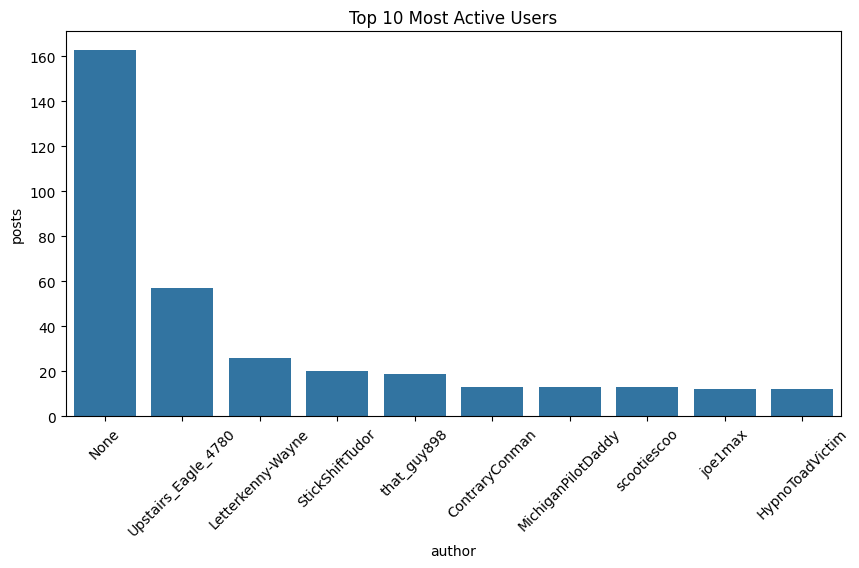

In [41]:

# Reconnect to the database
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # replace with your actual password
    host="localhost",
    port="5432"
)
sql = lambda query: pd.read_sql(query, conn)

# Plot top 10 most active users from the comments table
df_users = sql("SELECT author, COUNT(*) AS posts FROM comments GROUP BY author ORDER BY posts DESC LIMIT 10")
plt.figure(figsize=(10,5))
sns.barplot(data=df_users, x='author', y='posts')
plt.title('Top 10 Most Active Users')
plt.xticks(rotation=45)
plt.show()

conn.close()


2. Comments Over Time (Line Plot)


/tmp/ipykernel_1739631/1797202088.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


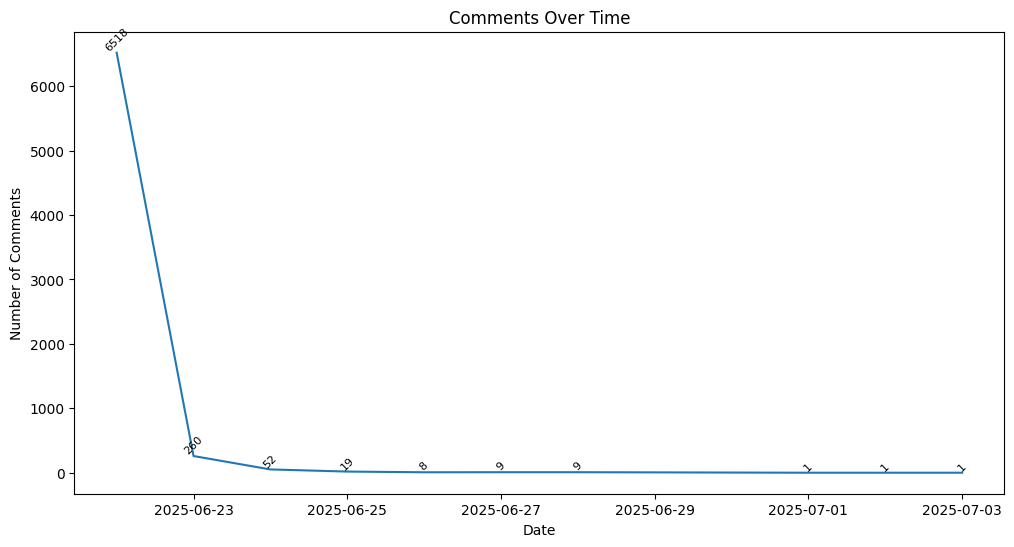

In [55]:
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # replace with your actual password
    host="localhost",
    port="5432"
)
sql = lambda query: pd.read_sql(query, conn)
# Plot comments over time
df_time = sql("SELECT DATE_TRUNC('day', created_utc) AS day, COUNT(*) AS count FROM comments GROUP BY day ORDER BY day")
plt.figure(figsize=(12,6))
sns.lineplot(data=df_time, x='day', y='count')
plt.title('Comments Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Comments')

# Annotate each point with its count
for x, y in zip(df_time['day'], df_time['count']):
    plt.text(x, y, str(y), ha='center', va='bottom', fontsize=8, rotation=45)

plt.show()
conn.close()

3. Sentiment Distribution (Histogram)


/tmp/ipykernel_1739631/904831364.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_none = pd.read_sql("SELECT * FROM comments WHERE sentiment IS NOT NULL", conn)


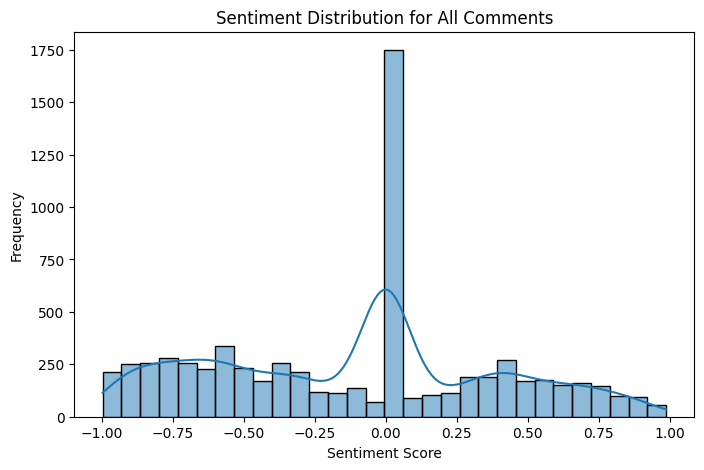

In [43]:
#sentiment distribution overall
import matplotlib.pyplot as plt
import seaborn as sns   
# Load comments with sentiment
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # replace with your actual PostgreSQL password
    host="localhost",
    port="5432"
)
df_none = pd.read_sql("SELECT * FROM comments WHERE sentiment IS NOT NULL", conn)   
plt.figure(figsize=(8,5))
sns.histplot(df_none['sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution for All Comments')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_1739631/2278301159.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


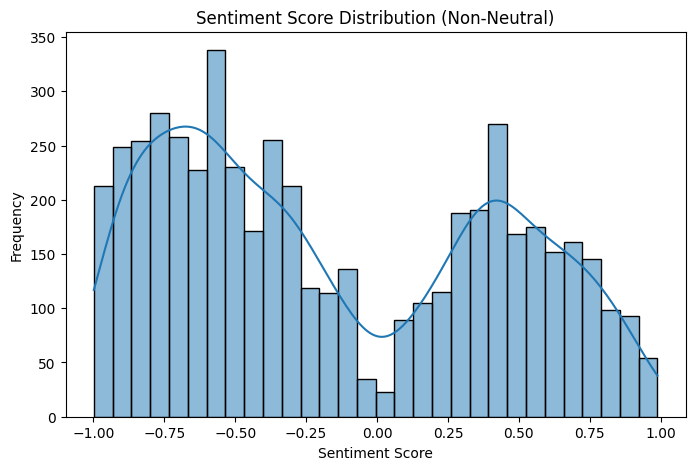

In [44]:
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # replace with your actual password
    host="localhost",
    port="5432"
)
sql = lambda query: pd.read_sql(query, conn)

# Filter out neutral sentiment (e.g., -0.05 <= sentiment <= 0.05)
df_sentiment = sql("SELECT sentiment FROM comments WHERE sentiment IS NOT NULL")
df_non_neutral = df_sentiment[(df_sentiment['sentiment'] < -0.05) | (df_sentiment['sentiment'] > 0.05)]

plt.figure(figsize=(8,5))
sns.histplot(df_non_neutral['sentiment'], bins=30, kde=True)
plt.title('Sentiment Score Distribution (Non-Neutral)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

4. Average Comment Length Over Time


/tmp/ipykernel_1739631/4161302880.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


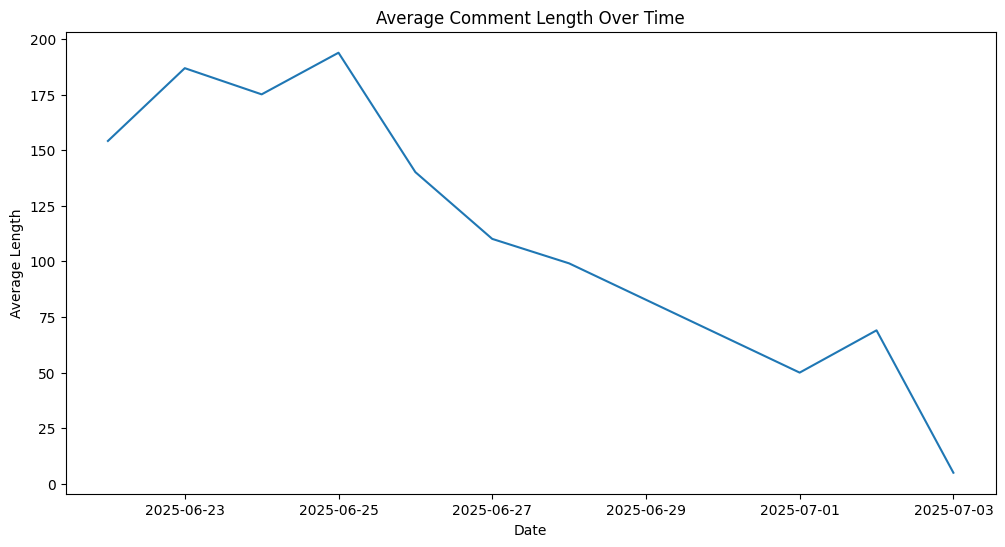

In [45]:
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # replace with your actual password
    host="localhost",
    port="5432"
)
sql = lambda query: pd.read_sql(query, conn)

df_length = sql("""
    SELECT DATE_TRUNC('day', created_utc) AS day, AVG(CHAR_LENGTH(body)) AS avg_length
    FROM comments
    GROUP BY day
    ORDER BY day
""")
plt.figure(figsize=(12,6))
sns.lineplot(data=df_length, x='day', y='avg_length')
plt.title('Average Comment Length Over Time')
plt.xlabel('Date')
plt.ylabel('Average Length')
plt.show()


5. Most associated words when Trumpo was mentioned

/tmp/ipykernel_1739631/4161302880.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


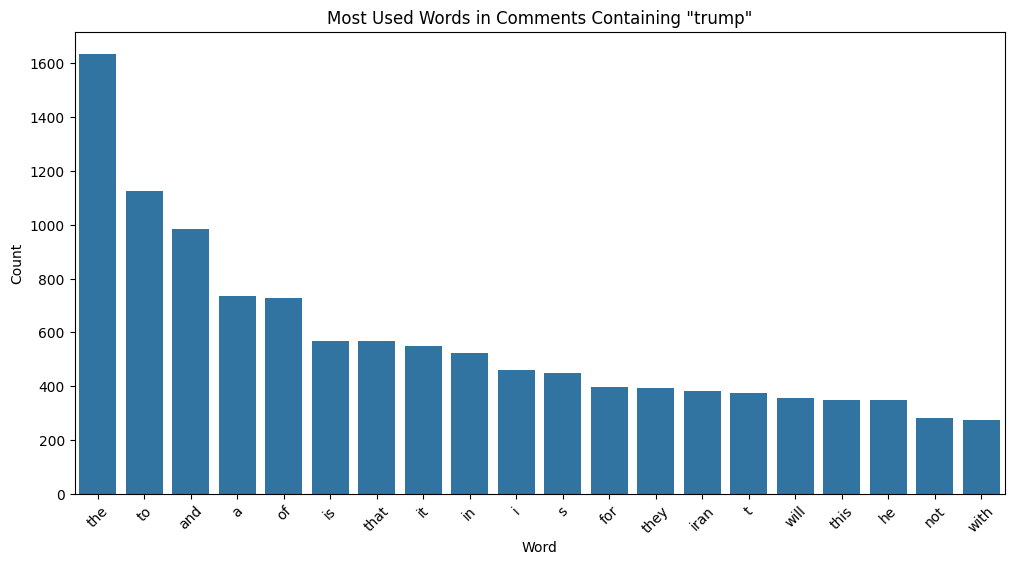

In [46]:
# Get all comments containing "trump"
df_trump = sql("SELECT body FROM comments WHERE LOWER(body) LIKE '%trump%'")

# Tokenize and count words
all_words = []
for text in df_trump['body']:
    # Remove punctuation and split into words
    words = re.findall(r'\b\w+\b', str(text).lower())
    all_words.extend(words)

# Remove the word "trump" itself from the count
filtered_words = [w for w in all_words if w != "trump"]

# Count and get the most common words
word_counts = Counter(filtered_words)
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts))
plt.title('Most Used Words in Comments Containing "trump"')
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

6. Avrg Sentiment by Day

/tmp/ipykernel_1739631/4161302880.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


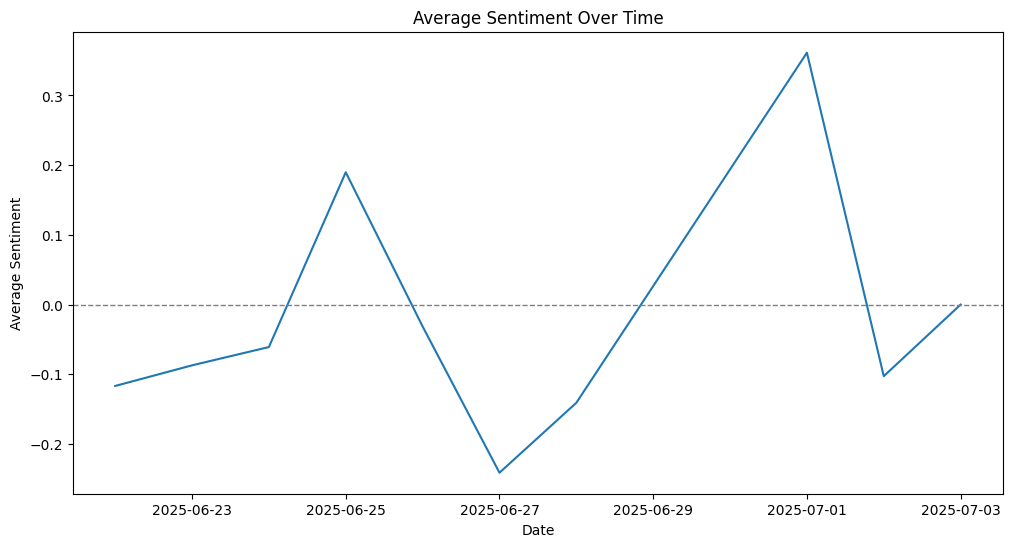

In [47]:
# Get average sentiment per day
df_sentiment_time = sql("""
    SELECT DATE_TRUNC('day', created_utc) AS day, AVG(sentiment) AS avg_sentiment
    FROM comments
    WHERE sentiment IS NOT NULL
    GROUP BY day
    ORDER BY day
""")

plt.figure(figsize=(12,6))
sns.lineplot(data=df_sentiment_time, x='day', y='avg_sentiment')
plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()



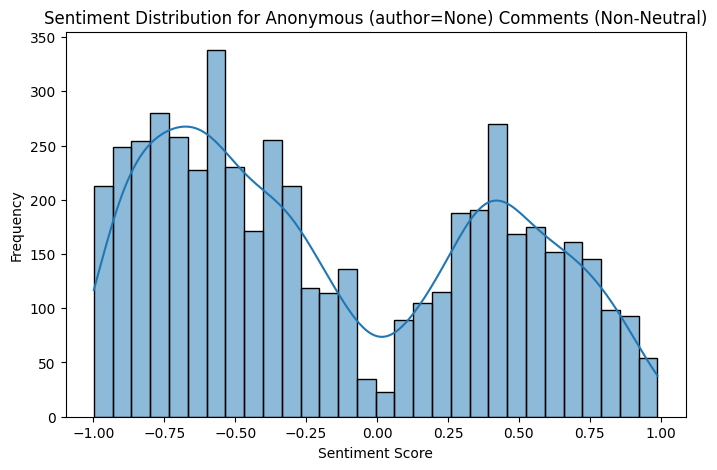

In [48]:
# Disregard neutral sentiment (e.g., -0.05 <= sentiment <= 0.05)
df_non_neutral = df_none[(df_none['sentiment'] < -0.05) | (df_none['sentiment'] > 0.05)]

plt.figure(figsize=(8,5))
sns.histplot(df_non_neutral['sentiment'], bins=30, kde=True)
plt.title('Sentiment Distribution for Anonymous (author=None) Comments (Non-Neutral)')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_1739631/2717098934.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


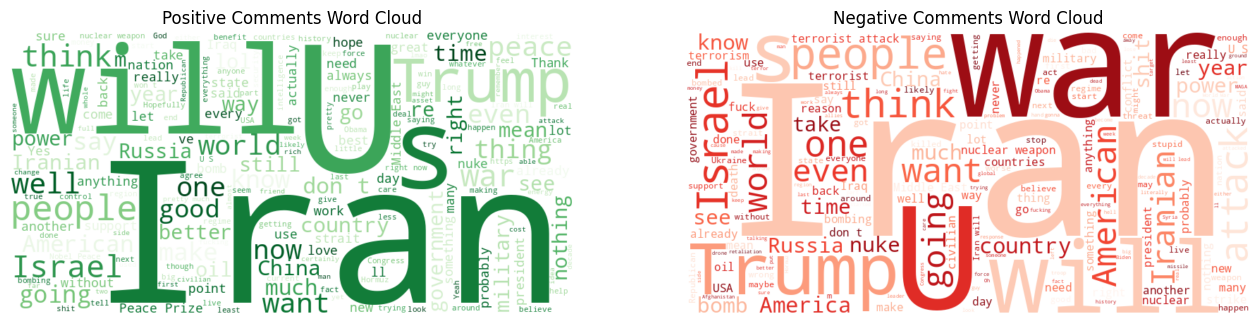

In [49]:
# Reconnect to the database
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",
    host="localhost",
    port="5432"
)
sql = lambda query: pd.read_sql(query, conn)

# Get positive and negative comments
df_pos = sql("SELECT body FROM comments WHERE sentiment >= 0.5 AND body IS NOT NULL")
df_neg = sql("SELECT body FROM comments WHERE sentiment <= -0.5 AND body IS NOT NULL")

# Combine all text for each group
text_pos = " ".join(df_pos['body'].astype(str))
text_neg = " ".join(df_neg['body'].astype(str))

# Generate word clouds
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(text_pos)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_neg)

# Plot
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Comments Word Cloud')

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Comments Word Cloud')

plt.show()

conn.close()

/tmp/ipykernel_1739631/3891096514.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT sentiment, score FROM comments WHERE sentiment IS NOT NULL AND score IS NOT NULL", conn)
/tmp/ipykernel_1739631/3891096514.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=support, x='sentiment_label', y='score', palette={'Positive':'green', 'Negative':'red'})


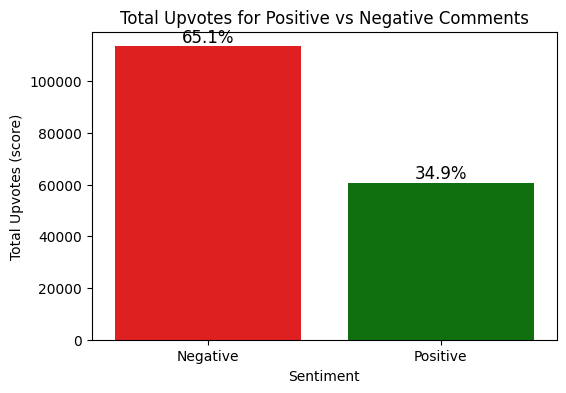

In [53]:
# Connect to the database and load sentiment and score
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # replace with your actual password
    host="localhost",
    port="5432"
)
df = pd.read_sql("SELECT sentiment, score FROM comments WHERE sentiment IS NOT NULL AND score IS NOT NULL", conn)
conn.close()

# Classify comments as positive or negative (neutral is ignored)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))
df = df[df['sentiment_label'] != 'Neutral']

# Group by sentiment and sum the scores
support = df.groupby('sentiment_label')['score'].sum().reset_index()

# Calculate percentage
total_score = support['score'].sum()
support['percentage'] = 100 * support['score'] / total_score

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=support, x='sentiment_label', y='score', palette={'Positive':'green', 'Negative':'red'})
for i, row in support.iterrows():
    plt.text(i, row['score'], f"{row['percentage']:.1f}%", ha='center', va='bottom', fontsize=12)
plt.title('Total Upvotes for Positive vs Negative Comments')
plt.xlabel('Sentiment')
plt.ylabel('Total Upvotes (score)')
plt.show()

/tmp/ipykernel_1739631/636308953.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sql = lambda query: pd.read_sql(query, conn)


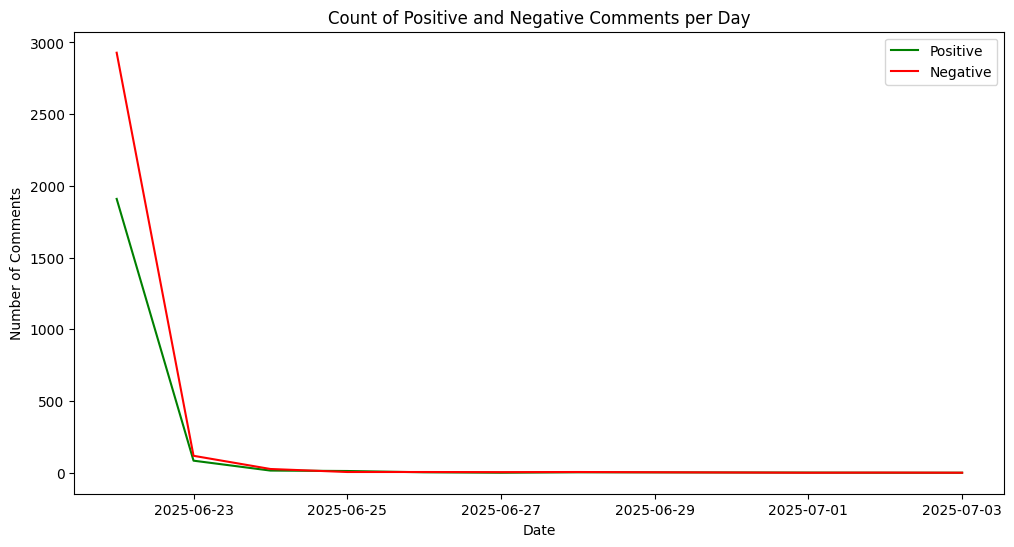

In [57]:
# Count of positive and negative comments per day
conn = psycopg2.connect(
    dbname="sentiment_analysis",
    user="alex",
    password="your_secure_password",  # replace with your actual password
    host="localhost",
    port="5432"
)
sql = lambda query: pd.read_sql(query, conn)

df_counts = sql("""
    SELECT 
        DATE_TRUNC('day', created_utc) AS day,
        COUNT(*) FILTER (WHERE sentiment > 0.05) AS positive_count,
        COUNT(*) FILTER (WHERE sentiment < -0.05) AS negative_count
    FROM comments
    WHERE sentiment IS NOT NULL
    GROUP BY day
    ORDER BY day
""")
conn.close()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_counts, x='day', y='positive_count', label='Positive', color='green')
sns.lineplot(data=df_counts, x='day', y='negative_count', label='Negative', color='red')
plt.title('Count of Positive and Negative Comments per Day')
plt.xlabel('Date')
plt.ylabel('Number of Comments')
plt.legend()
plt.show()